# Exploring Binary Classification on Hotdog-Nothotdog Dataset



# Introduction




##Define the Task
### The problem domain

The problem and therefore goal is to automatically classify the items into one of two categories using deep learning.


I will be using the Hotdog-nothotdog dataset which has been downloaded using the kaggle API and this is outlined in the code below.


As the dataset is relatively small, I will train a model from scratch using convnets and methodically adjust the structure and hyperparametetrs of the models in order to achieve high accuracy and low loss. This will be a continual process based on the results of the models performance during training and testing.


As there are two classes in this dataset, the images are either a hotdog or not a hotdog. Therefore the problem this focuses on is one of binary - classification.

I will be using binarycross-entropy as the loss function to solve this problem and will be adhering to the DL universal workflow throughout this investigation.


### The Dataset

The Hotdog-Nothotdog is a dataset containing 4,642 RGB images. It contains 4242 training images split into two classes, 2121 images of hotdogs and 2121 images of images that are not hotdogs.

The remaining 400 images are used for testing and again split into two classes, 200 in hotdog and 200 in nothotdog.



### Success

In order to measure success, after the model has been successfully trained and reached a sufficient accuracy and loss, it will then be evaluated by
its results on correctly classifying unseen images from test data into the correct category, again the metrics of the model's accuracy and loss used in part to evaluate this.



### Hypothesis


As such it can be hypothesized that the final model will achieve at least 80% accuracy on the test set and the dataset will be adequate to help achieve this.



### Helper Functions

I created them to speed up the process of plotting results of each individual model

In [1]:
# Helper Functions

def plot_model_results(results, model_name):


    plt.clf()

    loss = results.history['loss']
    val_loss = results.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(model_name + ' Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    print(model_name + ': Min Training Loss: ', min(loss))
    print(model_name + ': Min Validation Loss: ', min(val_loss))



    plt.figure()

    acc = results.history['accuracy']
    val_acc = results.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(model_name + ' Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    print(model_name + ': Max Training Acc: ', max(acc))
    print(model_name + ': Max Validation Acc: ', max(val_acc))




def compare_model_results(results1,results2,newest_model,prev_model):

    plt.clf()

    val_loss_new = results1.history['val_loss']
    val_loss_prev = results2.history['val_loss']

    epochs = range(1, len(val_loss_new) + 1)

    plt.plot(epochs, val_loss_prev, 'b+', label=prev_model)
    plt.plot(epochs, val_loss_new, 'bo', label=newest_model)
    plt.title(newest_model + ' Vs ' + prev_model)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()

    print(newest_model + ': Min Validation Loss: ', min(val_loss_new))
    print(prev_model + ': Min Validation Loss: ', min(val_loss_prev))




    plt.figure()

    val_acc_new = results1.history['val_accuracy']
    val_acc_prev = results2.history['val_accuracy']

    plt.plot(epochs, val_acc_prev, 'b+', label=prev_model)
    plt.plot(epochs, val_acc_new, 'bo', label=newest_model)
    plt.title(newest_model + ' Vs ' + prev_model)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()

    plt.show()

    print(newest_model + ': Max Validation Acc: ', max(val_acc_new))
    print(prev_model + ': Max Validation Acc: ', max(val_acc_prev))

# Methodology

# 2.Develop a Model


### What is the common sense baseline?

Despite the dataset being external from kaggle and not one from tesnorflow, the dataset is balanced and I have also taken steps to confirm this outlined in the below code.


The dataset is balanced and has an equal number of images to its two categories. This means the baseline accuracy the model should have is 50%.

This is the probability of the model correctly predicting the category for an image by chance, which is a 1 in 2 chance for the model for each prediction.

This serves as a benchmark for the model and a target for the model to improve its accuracy higher than 50%.


### Load the Data

The Hotdog-nothotdog dataset, containing images & labels is loaded before pre-processing.

The steps below are how to download the dataset into collab using Kaggle's API.

1. You need to create a Kaggle API key by signing up on Kaggle's website and creating an account. In you account settings you click 'Create New API Token' this generates a kaggle.json file which will download to your computer.

2. Upload the API key's JSON file by running this code, click choose file and select kaggle.json



In [2]:
from google.colab import files

# Upload kaggle.json file
uploaded = files.upload()


Saving kaggle.json to kaggle.json


3. This step creates a kaggle folder and copys the API key file to it.


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


4. Run this code to download the dataset to the /content file inside collab.

In [4]:
!kaggle datasets download -d thedatasith/hotdog-nothotdog

 96% 203M/211M [00:02<00:00, 86.6MB/s]
100% 211M/211M [00:02<00:00, 93.6MB/s]


5. As the dataset is compressed, run this code to unzip it in order to access it in the model.


In [5]:
!unzip -qq hotdog-nothotdog.zip


###Loading the images from the directory

As shown below, the Dataset is loaded from the content directory on collab. The Training data and test data are inside different folders in the directory and so the structure of the dataset is correctly organised and balanced. The data is loaded into 2 different variables, one for test data and one for training data. The validation data is a 20% split of the training data.

All of The images are resized to 180x180 pixels and the dataset is put into batches of 32 images. This is in order to feed the network images of the same size to ensure consistency and optimal learning by the model.



### Understanding the Dataset

The images displayed below shows us examples we are working with. The images are labelled 0 if they belong to the hotdog class and 1 if they are not a hotdog. For example the image of a mouse below is clearly not a hotdog and so is labelled with a 1.




Found 400 files belonging to 2 classes.
Found 4242 files belonging to 2 classes.
Using 3394 files for training.
Found 4242 files belonging to 2 classes.
Using 848 files for validation.


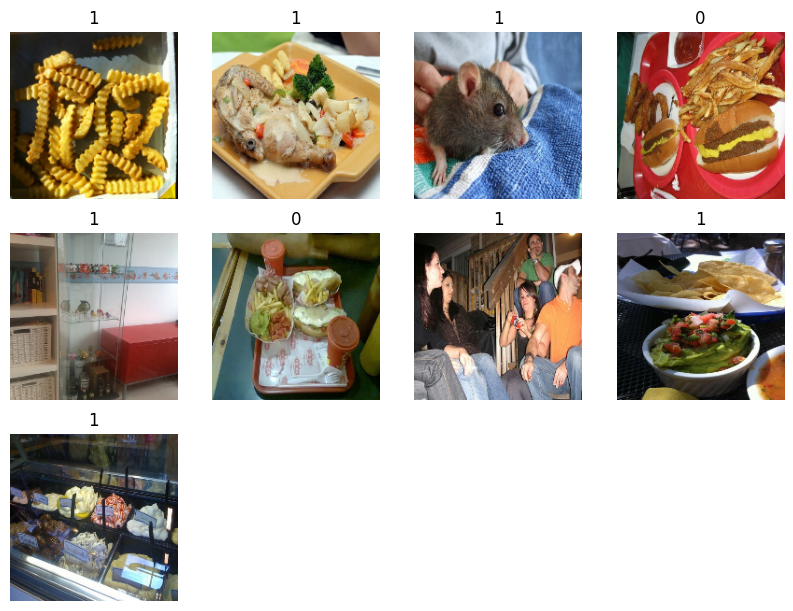

In [51]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf



new_base_dir = pathlib.Path("/content/hotdog-nothotdog/hotdog-nothotdog")


test_dataset = tf.keras.utils.image_dataset_from_directory(
new_base_dir / "test",
image_size=(180, 180),
batch_size=32
)




train_dataset = tf.keras.utils.image_dataset_from_directory(
    new_base_dir / "train",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    new_base_dir / "train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)


def display_images(dataset, number):
    plt.figure(figsize=(10, 10))

    for images, labels in dataset.take(1):
        for i in range(number):
            ax = plt.subplot(int(number**0.5) + 1, int(number**0.5)
             + 1, i + 1)

            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")

display_images(validation_dataset, 9)




#Model 1

### Building the first model


This first model achieves statistical power as it beats the common sense baseline of 50% accuracy.

As shown the model achieves a training accuracy of 0.92 and a validation accuracy of 0.75

This is evidence of overfitting as training accuracy gradually increases and reaches a high of 0.92, where as the validation accuracy fluctuates and only reaches a high of 0.75

This is the same for training loss, which decreases gradually and reaches 0.16. However validation loss fluctuates and is not consistent with the training loss and reaches 0.55

I will now attempt to regularize and tune the model in order to reduce overfitting and increase validation accuracy and decrease validation loss.


Epoch 1/15
107/107 [==============================] - 9s 56ms/step - loss: 0.6885 - accuracy: 0.5689 - val_loss: 0.7293 - val_accuracy: 0.6439
Epoch 2/15
107/107 [==============================] - 7s 66ms/step - loss: 0.6374 - accuracy: 0.6429 - val_loss: 0.6199 - val_accuracy: 0.6050
Epoch 3/15
107/107 [==============================] - 11s 102ms/step - loss: 0.6250 - accuracy: 0.6591 - val_loss: 0.6706 - val_accuracy: 0.5790
Epoch 4/15
107/107 [==============================] - 6s 54ms/step - loss: 0.6089 - accuracy: 0.6771 - val_loss: 0.6771 - val_accuracy: 0.5884
Epoch 5/15
107/107 [==============================] - 7s 65ms/step - loss: 0.5803 - accuracy: 0.6998 - val_loss: 0.8153 - val_accuracy: 0.5165
Epoch 6/15
107/107 [==============================] - 6s 54ms/step - loss: 0.5710 - accuracy: 0.7127 - val_loss: 0.9799 - val_accuracy: 0.5354
Epoch 7/15
107/107 [==============================] - 7s 66ms/step - loss: 0.5358 - accuracy: 0.7319 - val_loss: 0.8409 - val_accuracy: 0.56

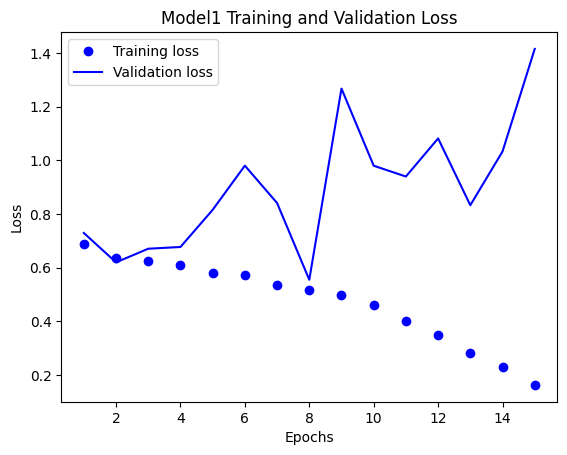

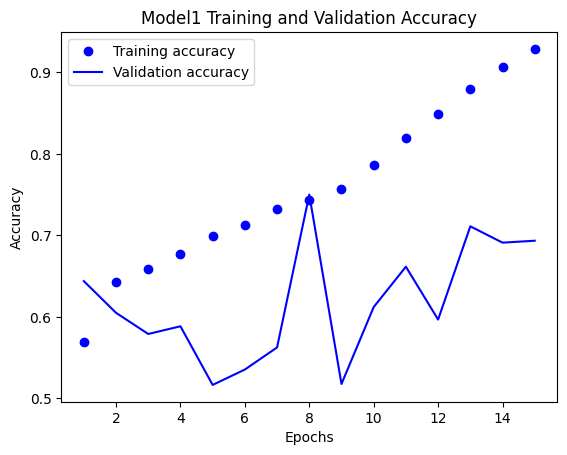

Model1: Max Training Acc:  0.9286977052688599
Model1: Max Validation Acc:  0.75


In [26]:


inputs = tf.keras.Input(shape=(180, 180, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])


model1 = model.fit(train_dataset, epochs=15,validation_data=validation_dataset)



# Results for Model 1

plot_model_results(model1, 'Model1')


##Model 2
###Adding an additional Convnet Layer to the model


In order to try and reduce overfitting I have added an additional convnet layer to the model to increase its complexity and therefore to improve the model's learning.

As shown by the model plots, adding an additional layer to the model has reduced some of the overfitting as from epochs 1 to 10 the training accuracy and training loss is more aligned with the validation accuracy and validation loss and respectively increases and decreases together which is an improvement against the previous architecure.

However past epoch 10 it is obvious there is a spike in validation loss and a huge decrease in validation accuracy so I will attempt to further tune the model and prevent the future overfitting.

Epoch 1/15
107/107 [==============================] - 8s 63ms/step - loss: 0.7067 - accuracy: 0.5271 - val_loss: 0.6965 - val_accuracy: 0.5094
Epoch 2/15
107/107 [==============================] - 6s 56ms/step - loss: 0.6809 - accuracy: 0.5787 - val_loss: 0.6563 - val_accuracy: 0.6392
Epoch 3/15
107/107 [==============================] - 7s 63ms/step - loss: 0.6497 - accuracy: 0.6299 - val_loss: 0.6307 - val_accuracy: 0.6450
Epoch 4/15
107/107 [==============================] - 6s 53ms/step - loss: 0.6230 - accuracy: 0.6597 - val_loss: 0.7495 - val_accuracy: 0.6274
Epoch 5/15
107/107 [==============================] - 7s 59ms/step - loss: 0.6072 - accuracy: 0.6800 - val_loss: 0.5966 - val_accuracy: 0.6745
Epoch 6/15
107/107 [==============================] - 6s 53ms/step - loss: 0.5867 - accuracy: 0.6989 - val_loss: 0.6087 - val_accuracy: 0.6733
Epoch 7/15
107/107 [==============================] - 8s 71ms/step - loss: 0.5612 - accuracy: 0.7207 - val_loss: 0.6040 - val_accuracy: 0.6675

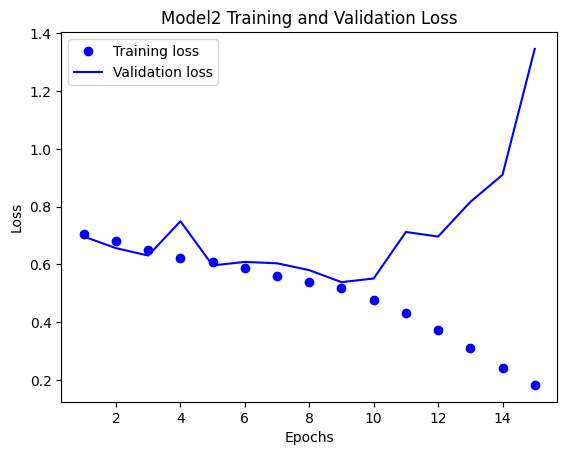

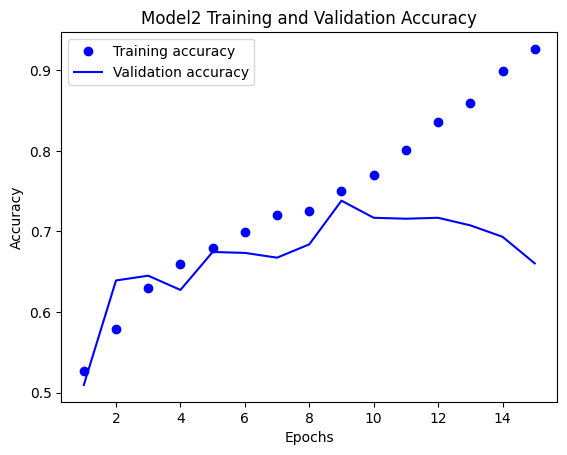

Model2: Max Training Acc:  0.9266352653503418
Model2: Max Validation Acc:  0.7382075190544128
Model1: Min Validation Loss:  0.5551711320877075
Model2: Min Validation Loss:  0.5387324690818787


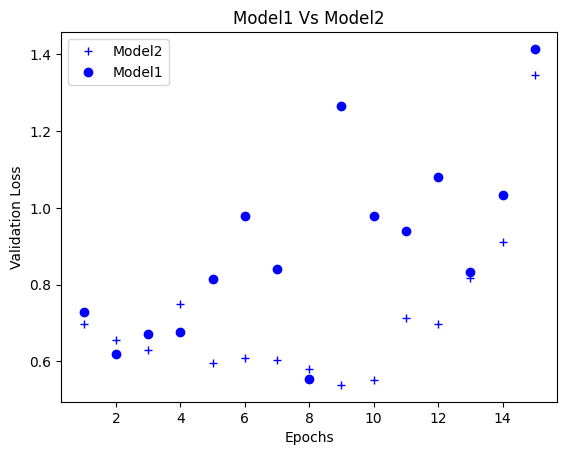

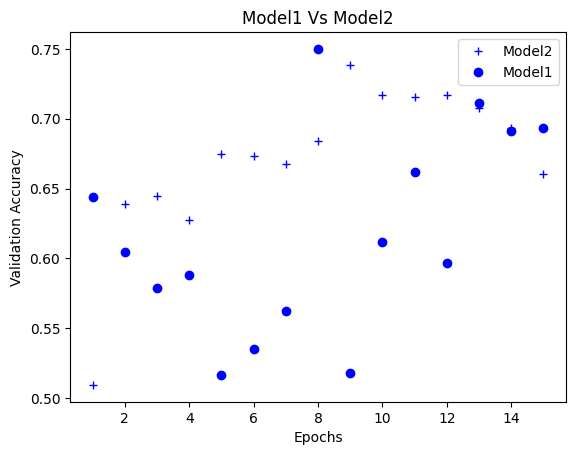

Model1: Max Validation Acc:  0.75
Model2: Max Validation Acc:  0.7382075190544128


In [28]:
# Model 2 - adding another layer with 16 filters

inputs = tf.keras.Input(shape=(180, 180, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.Flatten()(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])


model2 = model.fit(train_dataset, epochs=15,validation_data=validation_dataset)


plot_model_results(model2, 'Model2')

compare_model_results(model1,model2,'Model1','Model2')




#Model 3


### Adding Dropout

Continuing with the model architecture from model 2, in order to reduce further overfitting, a dropout layer of 0.5 is added to this model.

There is not a significant improvement in the model's performance, In order to ensure training accuracy and loss remains high and overfitting is reduced ,I will add data augmentation alongside the dropout layer and review the results.






Epoch 1/15
107/107 [==============================] - 8s 54ms/step - loss: 0.6959 - accuracy: 0.5501 - val_loss: 0.6259 - val_accuracy: 0.6627
Epoch 2/15
107/107 [==============================] - 8s 71ms/step - loss: 0.6519 - accuracy: 0.6349 - val_loss: 0.6087 - val_accuracy: 0.6509
Epoch 3/15
107/107 [==============================] - 6s 53ms/step - loss: 0.6310 - accuracy: 0.6585 - val_loss: 1.0841 - val_accuracy: 0.5153
Epoch 4/15
107/107 [==============================] - 7s 64ms/step - loss: 0.6173 - accuracy: 0.6797 - val_loss: 1.0211 - val_accuracy: 0.5212
Epoch 5/15
107/107 [==============================] - 6s 53ms/step - loss: 0.6065 - accuracy: 0.6853 - val_loss: 0.5903 - val_accuracy: 0.6851
Epoch 6/15
107/107 [==============================] - 6s 50ms/step - loss: 0.5789 - accuracy: 0.7033 - val_loss: 0.5463 - val_accuracy: 0.7229
Epoch 7/15
107/107 [==============================] - 7s 63ms/step - loss: 0.5598 - accuracy: 0.7166 - val_loss: 0.7578 - val_accuracy: 0.6333

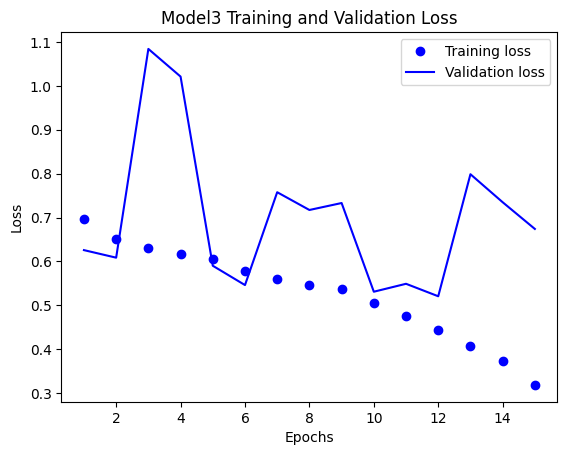

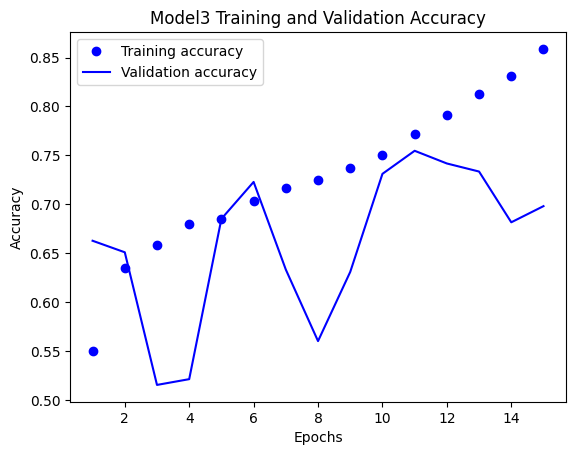

Model3: Max Training Acc:  0.8588685989379883
Model3: Max Validation Acc:  0.7547169923782349
Model2: Min Validation Loss:  0.5387324690818787
Model3: Min Validation Loss:  0.5207985639572144


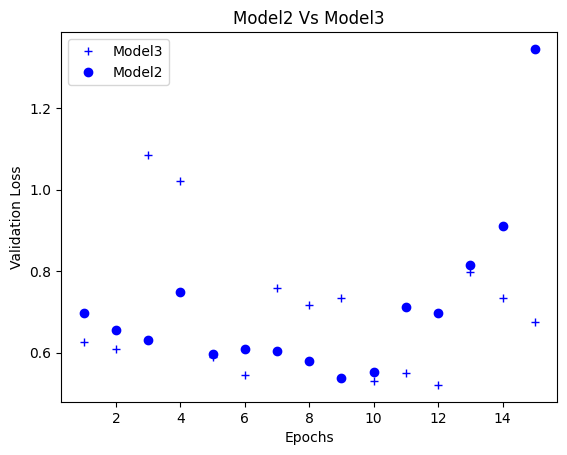

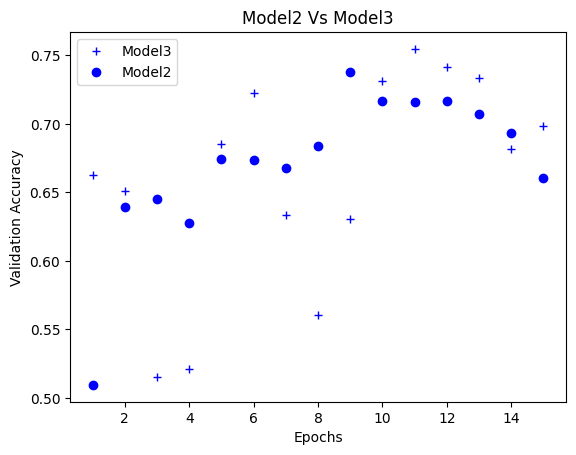

Model2: Max Validation Acc:  0.7382075190544128
Model3: Max Validation Acc:  0.7547169923782349


In [29]:
# Model 3

# adding dropout

inputs = tf.keras.Input(shape=(180, 180, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])



# Training Model 3

model3 = model.fit(train_dataset, epochs=15,validation_data=validation_dataset)



# Results for Model 3

plot_model_results(model3,'Model3')

compare_model_results(model2,model3,'Model2','Model3')





# Model 4


### Data Augmentation & Dropout Layer of 0.5

Although adding data augmentation alongside a dropout layer has reduced overfitting for this model as shown in the training loss and validation loss decreasing in a similar way, the validation loss reaching 0.57 and training loss reaching 0.52. There is a significant decrease in model performance comapared with model 2. Model 2's training accuracy is 0.92 where as the training accuracy for this model is 0.75.


Epoch 1/15
107/107 [==============================] - 9s 66ms/step - loss: 4.2920 - accuracy: 0.5233 - val_loss: 0.7188 - val_accuracy: 0.4906
Epoch 2/15
107/107 [==============================] - 6s 51ms/step - loss: 0.7346 - accuracy: 0.5168 - val_loss: 1.0575 - val_accuracy: 0.5047
Epoch 3/15
107/107 [==============================] - 7s 65ms/step - loss: 0.7021 - accuracy: 0.5760 - val_loss: 0.6089 - val_accuracy: 0.6592
Epoch 4/15
107/107 [==============================] - 6s 50ms/step - loss: 0.6879 - accuracy: 0.6008 - val_loss: 0.6255 - val_accuracy: 0.6851
Epoch 5/15
107/107 [==============================] - 8s 72ms/step - loss: 0.6564 - accuracy: 0.6237 - val_loss: 0.6802 - val_accuracy: 0.6439
Epoch 6/15
107/107 [==============================] - 6s 51ms/step - loss: 0.6475 - accuracy: 0.6641 - val_loss: 0.7039 - val_accuracy: 0.6675
Epoch 7/15
107/107 [==============================] - 7s 64ms/step - loss: 0.6225 - accuracy: 0.6889 - val_loss: 0.5746 - val_accuracy: 0.7241

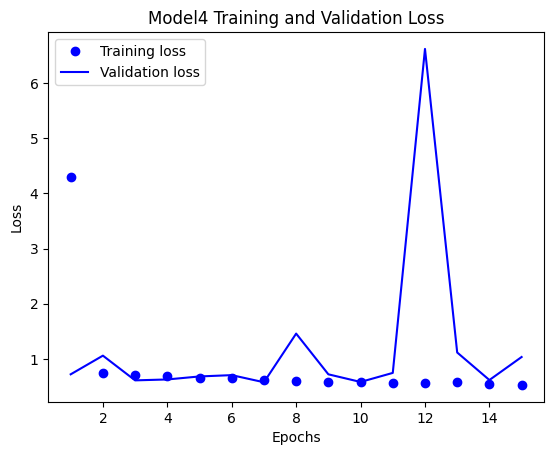

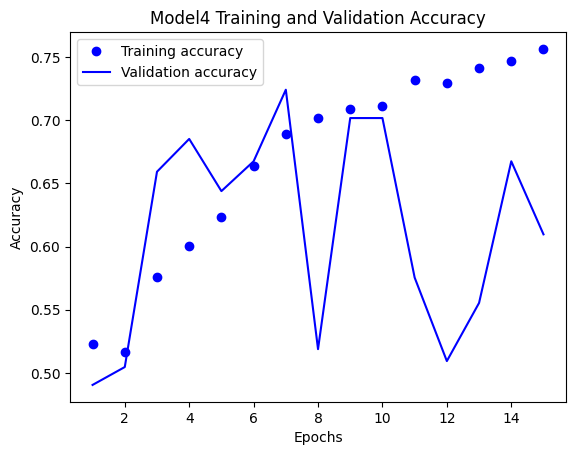

Model4: Max Training Acc:  0.7563347220420837
Model4: Max Validation Acc:  0.724056601524353
Model2: Min Validation Loss:  0.5387324690818787
Model4: Min Validation Loss:  0.5746235847473145


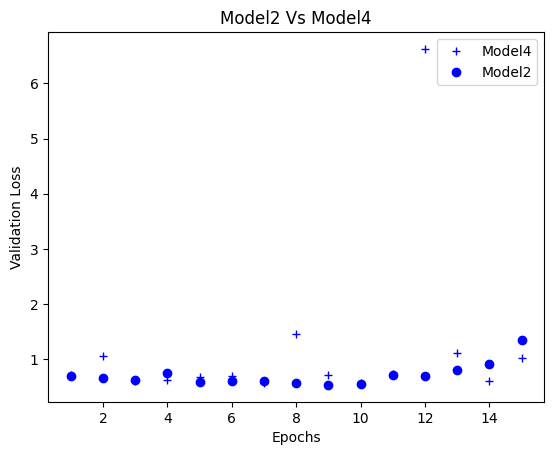

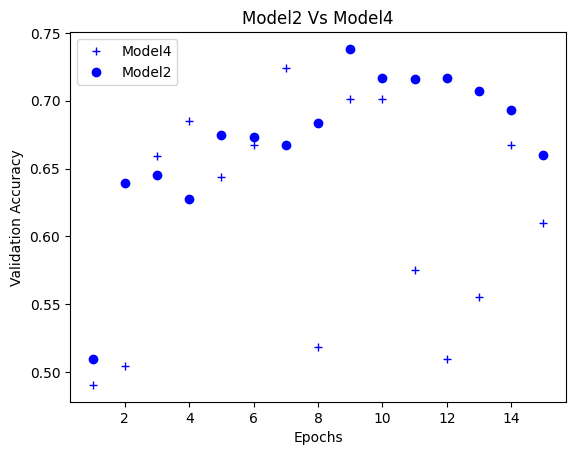

Model2: Max Validation Acc:  0.7382075190544128
Model4: Max Validation Acc:  0.724056601524353


In [31]:
#Model 4


# 1
data_augmentation = tf.keras.Sequential(
            [
               tf.keras.layers.RandomFlip("horizontal"),
               tf.keras.layers.RandomRotation(0.1),
               tf.keras.layers.RandomZoom(0.2),
] )

# 1

inputs = tf.keras.Input(shape=(180, 180, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = data_augmentation(inputs)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])


model4 = model.fit(train_dataset, epochs=15,validation_data=validation_dataset)




# Results for Model 4

plot_model_results(model4, 'Model4')

compare_model_results(model2,model4,'Model2','Model4')



##Model 5

###Increased Epochs

In order to see a potential improvement in model performance, I have extended the epochs from 15 to 35. As shown by the model plots, there is better performance in both validation accuracy and validation loss and as there are reduced fluctations in the later epochs it suggests that this model is starting to generalize better. Although its training accuracy compared with Model 2 is lower, the validation loss and validation accuracy is an improvement which is potential evidence that overfitting is in fact being reduced.


Epoch 1/35
107/107 [==============================] - 8s 52ms/step - loss: 3.8488 - accuracy: 0.5233 - val_loss: 2.1799 - val_accuracy: 0.4906
Epoch 2/35
107/107 [==============================] - 7s 64ms/step - loss: 0.7312 - accuracy: 0.5439 - val_loss: 4.8224 - val_accuracy: 0.5094
Epoch 3/35
107/107 [==============================] - 7s 63ms/step - loss: 0.7291 - accuracy: 0.5598 - val_loss: 0.6869 - val_accuracy: 0.5908
Epoch 4/35
107/107 [==============================] - 6s 53ms/step - loss: 0.6850 - accuracy: 0.6067 - val_loss: 0.6361 - val_accuracy: 0.6356
Epoch 5/35
107/107 [==============================] - 6s 56ms/step - loss: 0.6633 - accuracy: 0.6441 - val_loss: 0.6082 - val_accuracy: 0.6781
Epoch 6/35
107/107 [==============================] - 6s 50ms/step - loss: 0.6350 - accuracy: 0.6609 - val_loss: 0.6635 - val_accuracy: 0.5991
Epoch 7/35
107/107 [==============================] - 7s 61ms/step - loss: 0.6115 - accuracy: 0.6815 - val_loss: 0.9460 - val_accuracy: 0.6014

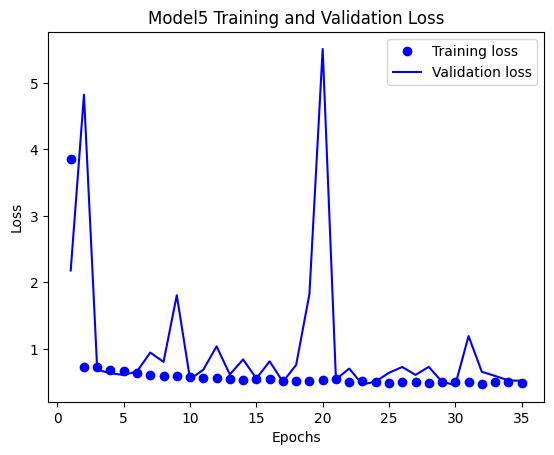

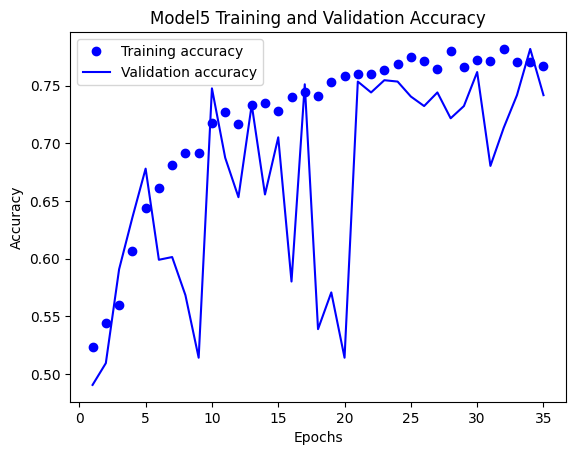

Model5: Max Training Acc:  0.7816735506057739
Model5: Max Validation Acc:  0.7818396091461182


In [33]:
#Model 5

# 1

data_augmentation = tf.keras.Sequential(
            [
               tf.keras.layers.RandomFlip("horizontal"),
               tf.keras.layers.RandomRotation(0.1),
               tf.keras.layers.RandomZoom(0.2),
] )

# 1


inputs = tf.keras.Input(shape=(180, 180, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = data_augmentation(inputs)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])


model5 = model.fit(train_dataset, epochs=35,validation_data=validation_dataset)




# Results for Model 5

plot_model_results(model5, 'Model5')


#Model 6

###Changing Kernel Size to 2

Although potential overfitting has been reduced with the implementation of data augmentation and a dropout layer, it is evident the training accuracy and training loss for the previous model's is too low compared with model2's performance. I have changed the kernel size from 3 to 2 to try to change this.

As shown by the model's results, there is still overfitting present. However, the change in kernel size has caused higher traning accuracy and lower training loss. There is also an improvement in both the validation accuracy and validation loss.

Epoch 1/35
107/107 [==============================] - 8s 52ms/step - loss: 1.6940 - accuracy: 0.5286 - val_loss: 0.7157 - val_accuracy: 0.5094
Epoch 2/35
107/107 [==============================] - 7s 66ms/step - loss: 0.6998 - accuracy: 0.5681 - val_loss: 0.6623 - val_accuracy: 0.6156
Epoch 3/35
107/107 [==============================] - 9s 79ms/step - loss: 0.6636 - accuracy: 0.6146 - val_loss: 0.6493 - val_accuracy: 0.6167
Epoch 4/35
107/107 [==============================] - 6s 53ms/step - loss: 0.6596 - accuracy: 0.6314 - val_loss: 0.8338 - val_accuracy: 0.5177
Epoch 5/35
107/107 [==============================] - 6s 51ms/step - loss: 0.6447 - accuracy: 0.6447 - val_loss: 0.6968 - val_accuracy: 0.6875
Epoch 6/35
107/107 [==============================] - 7s 66ms/step - loss: 0.6231 - accuracy: 0.6850 - val_loss: 0.9901 - val_accuracy: 0.5189
Epoch 7/35
107/107 [==============================] - 7s 65ms/step - loss: 0.5945 - accuracy: 0.6903 - val_loss: 0.5387 - val_accuracy: 0.7347

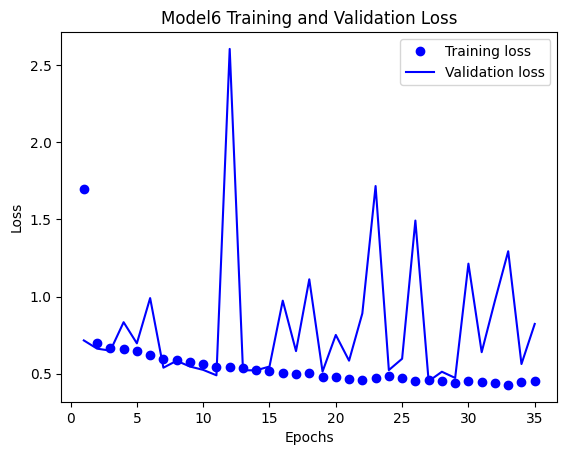

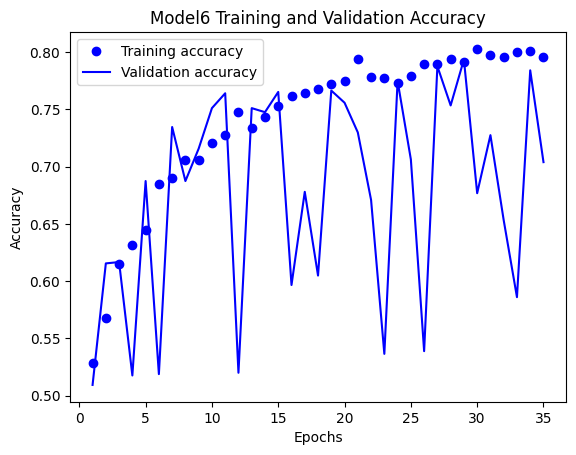

Model6: Max Training Acc:  0.8028874397277832
Model6: Max Validation Acc:  0.7936320900917053
Model5: Min Validation Loss:  0.45978817343711853
Model6: Min Validation Loss:  0.45121508836746216


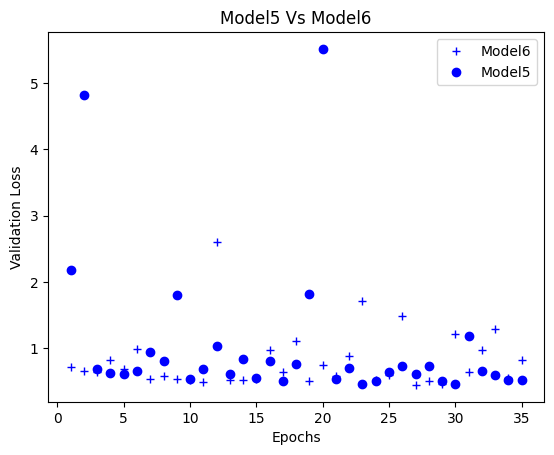

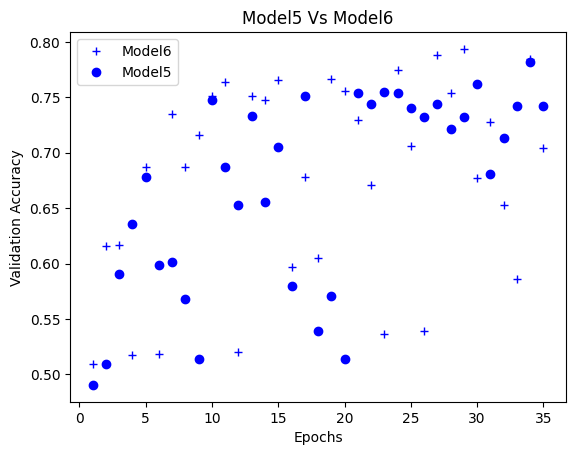

Model5: Max Validation Acc:  0.7818396091461182
Model6: Max Validation Acc:  0.7936320900917053


In [52]:
#Model 6

# 1
data_augmentation = tf.keras.Sequential(
            [
               tf.keras.layers.RandomFlip("horizontal"),
               tf.keras.layers.RandomRotation(0.1),
               tf.keras.layers.RandomZoom(0.2),
] )

# 1

inputs = tf.keras.Input(shape=(180, 180, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = data_augmentation(inputs)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=2, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=2, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=2, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=2, activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])


model6 = model.fit(train_dataset, epochs=35,validation_data=validation_dataset)




# Results for Model 6

plot_model_results(model6, 'Model6')

compare_model_results(model5,model6,'Model5','Model6')

##Model 7 - VGG

 Although overfitting has been reduced from adjusting the model's architecture and adding data augmentation, the overall performance of the previous model's is not satisfactory and is still too low. In order to achieve higher training accuracy and lower training loss, I will implement a pre-trained model and review the model's results.


There is still obvious overfitting present as shown by the model's results. However this architecture has achieved much better performance with a training loss of 0.006 and a significant training accuracy of 0.99. This will therefore be our final model and will be trained on the whole training dataset and evaluated on the test set


1/1 [==============================] - 0s 22ms/step
(3394, 5, 5, 512) (3394,)
Epoch 1/35
107/107 [==============================] - 2s 11ms/step - loss: 3.6715 - accuracy: 0.8111 - val_loss: 0.5019 - val_accuracy: 0.8526
Epoch 2/35
107/107 [==============================] - 1s 7ms/step - loss: 0.5322 - accuracy: 0.8939 - val_loss: 0.5079 - val_accuracy: 0.8785
Epoch 3/35
107/107 [==============================] - 1s 8ms/step - loss: 0.3280 - accuracy: 0.9275 - val_loss: 0.4971 - val_accuracy: 0.8892
Epoch 4/35
107/107 [==============================] - 1s 5ms/step - loss: 0.2175 - accuracy: 0.9505 - val_loss: 0.5938 - val_accuracy: 0.8974
Epoch 5/35
107/107 [==============================] - 1s 5ms/step - loss: 0.1886 - accuracy: 0.9611 - val_loss: 0.7100 - val_accuracy: 0.8903
Epoch 6/35
107/107 [==============================] - 1s 5ms/step - loss: 0.1538 - accuracy: 0.9664 - val_loss: 0.5909 - val_accuracy: 0.9080
Epoch 7/35
107/107 [==============================] - 1s 5ms/step - l

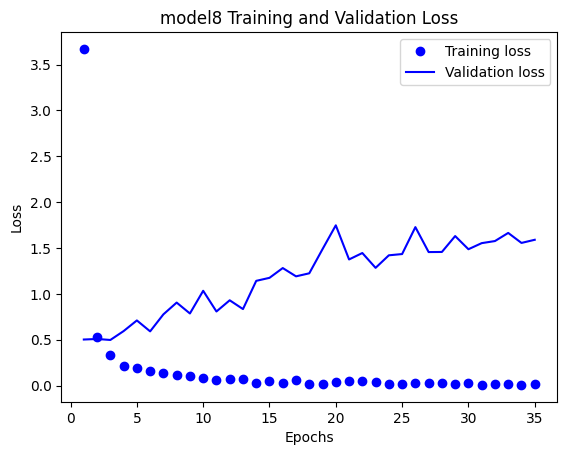

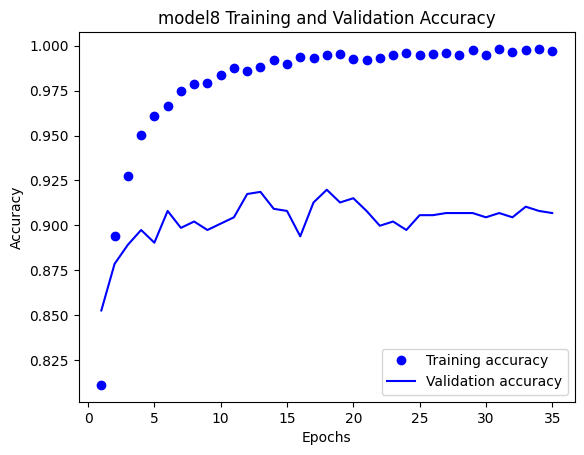

model8: Max Training Acc:  0.9982321858406067
model8: Max Validation Acc:  0.9198113083839417


In [38]:
# Model8 - VGG pre-trained

# 2
conv_base = tf.keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []

    for images, labels in dataset:
        preprocessed_images = tf.keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)

    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)


inputs = tf.keras.Input(shape=(5, 5, 512))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]

model8 = model.fit(
    train_features, train_labels,
    epochs=35,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

# 2

plot_model_results(model8, 'model8')






#Final Model


Based on the findings of the investigation, It's clear that although overfitting was reduced through the implementation of a dropout layer and data augmentation, the VGG architecture was significant in improving the model's performance


 I have trained the final model on the whole training set allowing the model to learn. I then evaluated the model using the test set which is unseen data, similar to a real world application of the model and so provides an unbiased result and accuracy of the model.


In [41]:

# Final Model - VGG pre-trained

# 2

conv_base = tf.keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []

    for images, labels in dataset:
        preprocessed_images = tf.keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)

    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)


inputs = tf.keras.Input(shape=(5, 5, 512))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


finalmodel = model.fit(
    train_features, train_labels,
    epochs=35)

# 2



model.evaluate(test_features,test_labels)


1/1 [==============================] - 0s 21ms/step
Epoch 1/35
107/107 [==============================] - 1s 4ms/step - loss: 5.0270 - accuracy: 0.8147
Epoch 2/35
107/107 [==============================] - 1s 5ms/step - loss: 0.5177 - accuracy: 0.8945
Epoch 3/35
107/107 [==============================] - 1s 5ms/step - loss: 0.4224 - accuracy: 0.9260
Epoch 4/35
107/107 [==============================] - 1s 5ms/step - loss: 0.3185 - accuracy: 0.9375
Epoch 5/35
107/107 [==============================] - 1s 5ms/step - loss: 0.2272 - accuracy: 0.9555
Epoch 6/35
107/107 [==============================] - 1s 5ms/step - loss: 0.2254 - accuracy: 0.9588
Epoch 7/35
107/107 [==============================] - 1s 5ms/step - loss: 0.1742 - accuracy: 0.9655
Epoch 8/35
107/107 [==============================] - 0s 4ms/step - loss: 0.1336 - accuracy: 0.9729
Epoch 9/35
107/107 [==============================] - 0s 4ms/step - loss: 0.1074 - accuracy: 0.9806
Epoch 10/35
107/107 [===========================

[1.8021577596664429, 0.887499988079071]

##Conclusion

The final model produced from this investigation was a VGG pre-trained model architecture.

 The original model was a small convnet which I tried to develop and continually improve by adjusting different hyperparameters. However it  contained significant overfitting and low performance and so a different approach was needed.
 This could have been due to the dataset being an unpopular dataset, it may not be well maintained and flawed  despite the fact I did investigate the dataset prior to performing this investigation.


The final model results were impressive, an 88% accuracy on the unseen test data surpasses the baseline model of 50% accuracy by a considerable margin.

The model also achieved a training loss of 1.8 on the test data which can be considered to be a fair result.

In conclusion, the hypothesis was  reached as the final model's accuracy was very high on the test data and the final model beat the baseline accuracy of 50%. The results from this investigation shows the potential for deep learning models and their successful application in being used for solving binary classification problems.

##Code References


1. Lecture code - https://goldsmiths.cloud.panopto.eu/Panopto/Pages/Viewer.aspx?id=9cc6943f-758c-4eac-8460-b0bd00d8fca3 (49:27)

2.Lecture code - https://goldsmiths.cloud.panopto.eu/Panopto/Pages/Viewer.aspx?id=9cc6943f-758c-4eac-8460-b0bd00d8fca3 (1:03:01)



